In [1]:
#Utilities drop
#total Bsmt outlier
##![title](img/prepro.png)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def get_feat_count(all_data):
    num_feat = all_data.dtypes[all_data.dtypes != "object"].index
    con_feat=[]
    dis_feat=[]
    for feat in num_feat:
        uniq=all_data[feat].unique()
        if len(uniq)>20:
            con_feat.append(feat)
        if len(uniq)<=20:
            dis_feat.append(feat)
    cat_feat = all_data.dtypes[all_data.dtypes == "object"].index
    return num_feat,cat_feat,con_feat,dis_feat

In [103]:
def get_corr_list(_data,_feat,thr,enc):
    all_obj_data=_data.loc[:len(train),_feat].copy()
    all_obj_data['SalePrice']=train['SalePrice']
    target='SalePrice'
    if enc=='ord_enc':
        for feat in _feat:
            ordered_labels = all_obj_data.groupby([feat])[target].mean()
            ordered_labels=ordered_labels.sort_values().index
            ordinal_label = {}
            for i, k in enumerate(ordered_labels, 0):
                ordinal_label[k]=i
            #print(ordinal_label)
            all_obj_data.loc[:,feat]=all_obj_data.loc[:,feat].map(ordinal_label)
    
    if enc=='lbl_enc':
        for col in _feat:
                lbl = LabelEncoder()
                lbl.fit(list(all_obj_data[col].values))
                all_obj_data[col] = lbl.transform(list(all_obj_data[col].values))

    corrmat = all_obj_data.corr()
    corrmat['corr_value']=corrmat['SalePrice'].abs()
    corrmat1=corrmat.sort_values( by=['corr_value'],ascending=False)
    cm=(corrmat1['corr_value'].abs())
    cm=pd.DataFrame(cm)
    corr_cols=list(cm[cm['corr_value']>thr].index)
    corr_cols=corr_cols[1:]
    
    return cm,corr_cols

In [104]:
def read_data():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    train.drop("Id",axis =1,inplace = True)
    test.drop("Id",axis =1,inplace= True)
    print('reading data done...')
    return train,test
def concate_data(train,test):
    all_data = pd.concat((train.loc[:, 'MSSubClass': 'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']),ignore_index=True)
    print("all_data size is: {} ".format(all_data.shape))
    print('Concating data done ...')
    return all_data

## Analysing correlation and ploting for the features having correlation with sale price more than 0.3

reading data done...
             corr_value
GrLivArea      0.708624
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
YearBuilt      0.522897


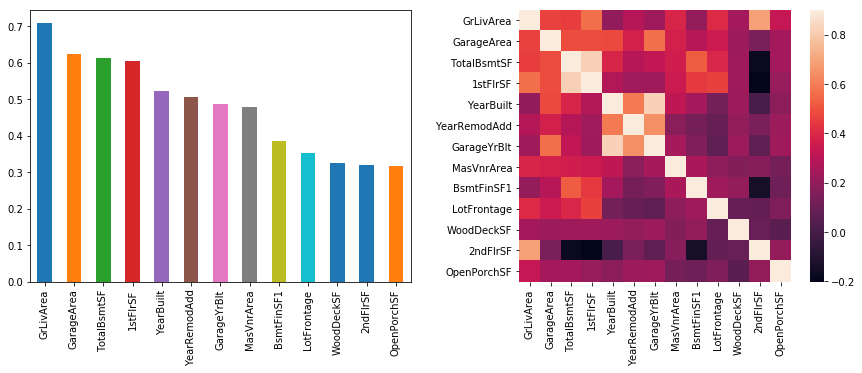

In [8]:
train,test=read_data()
data=train.copy()

num_feat,cat_feat,con_feat,dis_feat=get_feat_count(data)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

cm,corr_cols=get_corr_list(data,con_feat,0.3,enc='none')
cm.drop(['SalePrice'],inplace=True)
print(cm.head(5))
cm['corr_value'][cm['corr_value']>0.3].plot.bar(ax=axes[0])
#sns.pairplot(all_data[corr_cols[:4]])
#plt.show()
sns.heatmap(data[corr_cols].corr(),vmax=0.9, square=True,ax=axes[1])
plt.show()


In [121]:
cm.head(10)
len(num_feat)

38

# Handling Outlier 
1. Some of the features having high correlaion with target feature contain outliers
2. Remoiving outliers reduces error for only GrLivArea,TotalBsmtSF  

In [122]:
def remove_outlier(train):
    #train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
    train = train.drop(train[(train['GrLivArea']>4000)].index)
    train = train.drop(train[train['TotalBsmtSF']>6000].index)
    train=train.reset_index()
    print('removing oulier done...')
    return train

reading data done...
removing oulier done...
all_data size is: (2915, 79) 
Concating data done ...


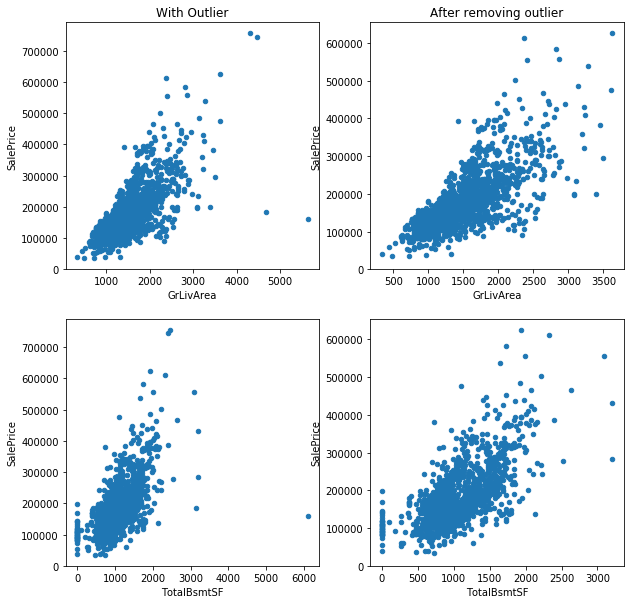

In [123]:

train,test=read_data()
cols=['GrLivArea','TotalBsmtSF']

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
train.plot.scatter(x=cols[0], y='SalePrice', ylim =10,ax=axes[0,0]);axes[0,0].set_title('With Outlier');
train.plot.scatter(x=cols[1], y='SalePrice', ylim =10,ax=axes[1,0]);axes[1,0]#.set_title('With Outlier');

train=remove_outlier(train)
all_data=concate_data(train,test)

train.plot.scatter(x=cols[0], y='SalePrice', ylim =10,ax=axes[0,1]);axes[0,1].set_title('After removing outlier');
train.plot.scatter(x=cols[1], y='SalePrice', ylim =10,ax=axes[1,1]);axes[1,1]#.set_title('With Outlier');

plt.show()

### Target feature Analysis
1. Target feature scewness ploting
2. Deviation from normalized distribution is observed
3. log applied for unscewing
4. plotting after unscewing

all_data size is: (2915, 79) 
Concating data done ...


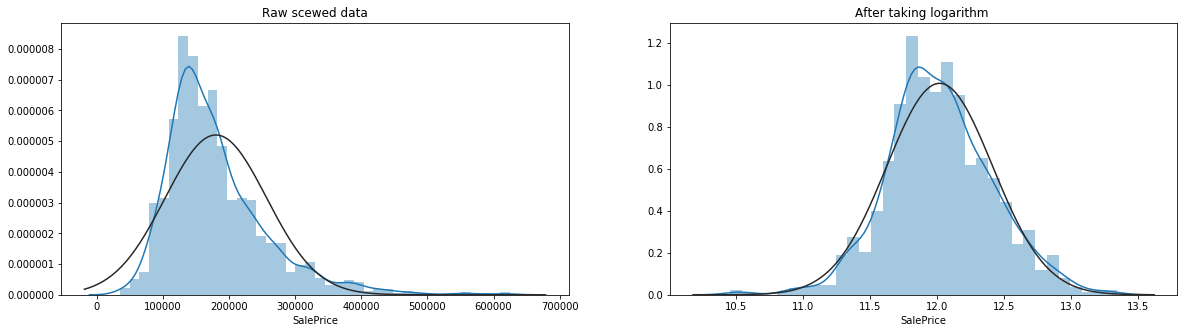

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
sns.distplot(train.SalePrice,fit=norm,ax=axes[0]); axes[0].set_title('Raw scewed data');


def unscew_target(train):
        train["SalePrice"] = np.log1p(train["SalePrice"])
        return train
#uc_train=train.copy()
train=unscew_target(train)
uc_all_data=concate_data(train,test)
sns.distplot(train.SalePrice,fit=norm,ax=axes[1]); axes[1].set_title('After taking logarithm ');
plt.show()

### Missing value analysis 
1. Missing value counting 
2. sorting by descending order of % missing value
3. Catagorizing Sorted features  

catagorical feat 43  missing value present in 23
numeric feat     36  missing value present in 11
continuous feat  21  missing value present in 8
discrete feat    15  missing value present in 3


Plot of missing value in descending order of their count :


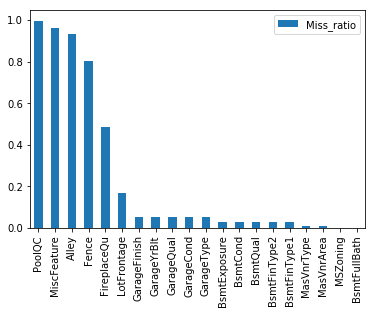

In [125]:
def missing_count(all_data):
    all_data_na = (all_data.isnull().sum()/ len(all_data)) * 1
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index)
    all_data_na=all_data_na.sort_values(ascending = False)
    missing_data =pd.DataFrame({'Miss_ratio':all_data_na[all_data_na>0.0]})
    miss_cols=list(missing_data.index)
    num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
    i=0
    m_cat_feat=[]
    m_con_feat=[]
    m_dis_feat=[]
    m_all=[]
    for col in miss_cols:
        if col in cat_feat:
            m_cat_feat.append(col)
            m_all.append('catagorical')
        if col in con_feat:
            m_con_feat.append(col)
            m_all.append('continuous')
        if col in dis_feat:
            m_dis_feat.append(col)
            m_all.append('discrete')
        i=i+1
    missing_data['type']=m_all    
    return missing_data,m_cat_feat,m_con_feat,m_dis_feat
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
miss_data,m_cat_cols,m_con_cols,m_dis_cols=missing_count(all_data)
print('catagorical feat',len(cat_feat),' missing value present in',len(m_cat_cols))
print('numeric feat    ',len(num_feat),' missing value present in',len(m_con_cols)+len(m_dis_cols))
print('continuous feat ',len(con_feat),' missing value present in',len(m_con_cols))
print('discrete feat   ',len(dis_feat),' missing value present in',len(m_dis_cols))
print('\n\nPlot of missing value in descending order of their count :')
miss_data[:20].plot.bar()
plt.show()

### Observations
Both Catagorical and Numarical feature contains significant number of features having missing values so they will be plotted separately for analysis.

#### Plotting Numeric features(Left) , Catagorical Features(Right) :In descending order of correlation with sale price
1. Bar plot indicates missing ratio in percentage(0.0-1.0)
2. line plot is the measure of correlation with target feature in range (0.0,1.0)
It helps to find the highly correlated columns having missing value


In descending order of correlation
1. bar plot is for missing ratio 
2. line plot is for correlation


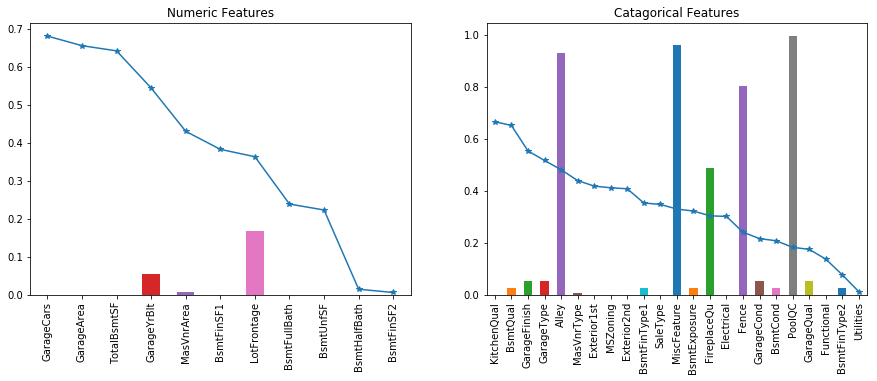

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

cm,corr_feat=get_corr_list(all_data,m_con_cols+m_dis_cols,thr=0,enc='none')
cm['miss_ratio']=0
for feat in corr_feat:
    cm.loc[feat,'miss_ratio']=miss_data.loc[feat,'Miss_ratio']
cm.drop(['SalePrice'],inplace=True)

print('In descending order of correlation\n1. bar plot is for missing ratio \n2. line plot is for correlation')
cm['corr_value'].plot(marker='*',ax=axes[0]);axes[0].set_title('Numeric Features');
cm['miss_ratio'].plot.bar(ax=axes[0]);



cm,corr_feat=get_corr_list(all_data,m_cat_cols,thr=0.0,enc='ord_enc')
cm['miss_ratio']=0
for feat in corr_feat:
    cm.loc[feat,'miss_ratio']=miss_data.loc[feat,'Miss_ratio']
cm.drop(['SalePrice'],inplace=True)
cm['corr_value'].plot(marker='*',ax=axes[1]);axes[1].set_title('Catagorical Features');
cm['miss_ratio'].plot.bar(ax=axes[1]);
plt.show()

# Findings from the above plot
1. Here 'LotFrontage', 'GarageYrBlt','TotalBsmtSF','MasVnrArea' seems to be important and will be considered specially during missing values
2. Here 'PoolQual', 'Alley', 'MiscFeature' seems to have high missing value but correlated resonably and will be considered specially during missing values.
3. Among these features 'KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical','MSZoning' these features are must for house so cannot be none or zero so they can be replaced by mode value instead.


### Handling missing values
 from the plot of continuous data with missing values it was found that 'LotFrontage', 'GarageYrBlt','TotalBsmtSF', 'MasVnrArea' have high correlation
1. 'LotFrontage' is replaced by median value of neighbourhood as houses having same neighbourhood have probability having same lotFrontage (I have found this information while reading about the data somewhere in internet)
2. 'GarageYrBlt' is replaced by zeero as no year built means no garage but another feture naming GarageYrBlt is created for compensation
3. 'TotalBsmtSF' , '1stFlrSF', '2ndFlrSF' is replaced by zero but another feature naming 'TotalSF' is added to compensate for the missing values
4. 'PoolQual', 'Alley', 'MiscFeature' have hign  missing value with resonably high correlation so dropping them was not a good idea at all but having no 'PoolQual' means no pool at all so they are replaced by 'Missing' label.
5. 'KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical','MSZoning'  are replaced by mode value the reason was explained earlier.
6. Rest of the continuous values are replaced by zero.
7. Rest of the catagirical values are replaed by 'Missing' label.


In [132]:

def handle_missing_values_new(data,m_cat_cols,m_con_cols,m_dis_cols):
    mode_cols=['MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical']
    for col in mode_cols:
        data[col] = data[col].fillna(data[col].mode()[0])

    
    data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    data['GarageYrBlt'].fillna(0)
    data['GarageYrBlt_NA'] =np.array(data['GarageYrBlt']>0)
    
    zero_cols=['TotalBsmtSF','1stFlrSF','2ndFlrSF']
    for col in zero_cols:
        data[col] = data[col].fillna(0)
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    
    #data=data.drop(columns=['Utilities'],axis=1)
    
    for col in m_cat_cols:
        data[col] = data[col].fillna('None')
    for col in m_con_cols:
        data[col] = data[col].fillna(0)
    for col in m_dis_cols:
        data[col]=data[col].fillna(0)
    print('Missing values handling done ...')
    return data
data=uc_all_data.copy()
no_miss_data=handle_missing_values_new(data,m_cat_cols,m_con_cols,m_dis_cols)

Missing values handling done ...


### Scewed Feature Handling
    1.Getting scewness of the numeric features
    2.Unscewing numeric features having high scew values

In [133]:
def get_skewness(skewed_data,feats,thr,sort=True):
    sk_df=skewed_data[feats].skew().abs()
    if sort==True:
        sk_df=sk_df.sort_values(ascending=False)
    #sk_df = skewed_data[feat].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)
    sk_df=pd.DataFrame({'Skew' :sk_df}) 
    sk_df.head(5)
    sk_cols=sk_df#[sk_df.Skew>thr]
    sk_cols=sk_cols.index.values.tolist()  
    return sk_cols,sk_df
def unscew_features(sk_data,sk_cols):
    from scipy.special import boxcox1p
    lam = 0.15
    for feat in sk_cols:
        sk_data[feat] = boxcox1p(sk_data[feat], lam)
    return sk_data

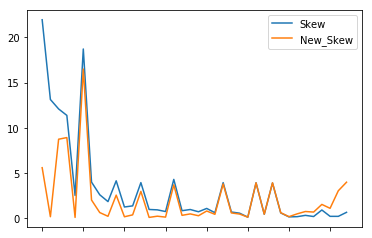

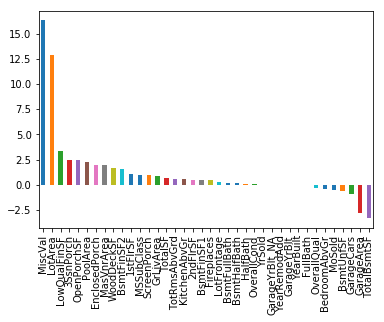

In [134]:
unskewed_data=no_miss_data.copy()
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(unskewed_data)

sk_cols,sk_df=get_skewness(unskewed_data,num_feat,0.75,sort=False)


unskewed_data=unscew_features(unskewed_data,sk_cols)
_,_sk_df=get_skewness(unskewed_data,num_feat,0.75,sort=False)

sk_df['New_Skew']=_sk_df['Skew']
sk_df['Diff']=sk_df['Skew']-sk_df['New_Skew']
sk_df.sort_values(by=['Diff'],inplace=True,ascending=False)
sk_df[['Skew','New_Skew']].plot()
plt.show()
sk_df['Diff'].plot.bar()
plt.show()
sk_cols=sk_df.index.values.tolist()

In [135]:
sk_df.head(5)

,Skew,New_Skew,Diff
MiscVal,21.943440,5.595745,16.347695
LotArea,13.130516,0.178615,12.951901
LowQualFinSF,12.086535,8.742416,3.344120
3SsnPorch,11.373947,8.923069,2.450879
OpenPorchSF,2.530548,0.100731,2.429817


### Plot of Some features fit with normaml distribution before and after unscewing
1. For some of the features like

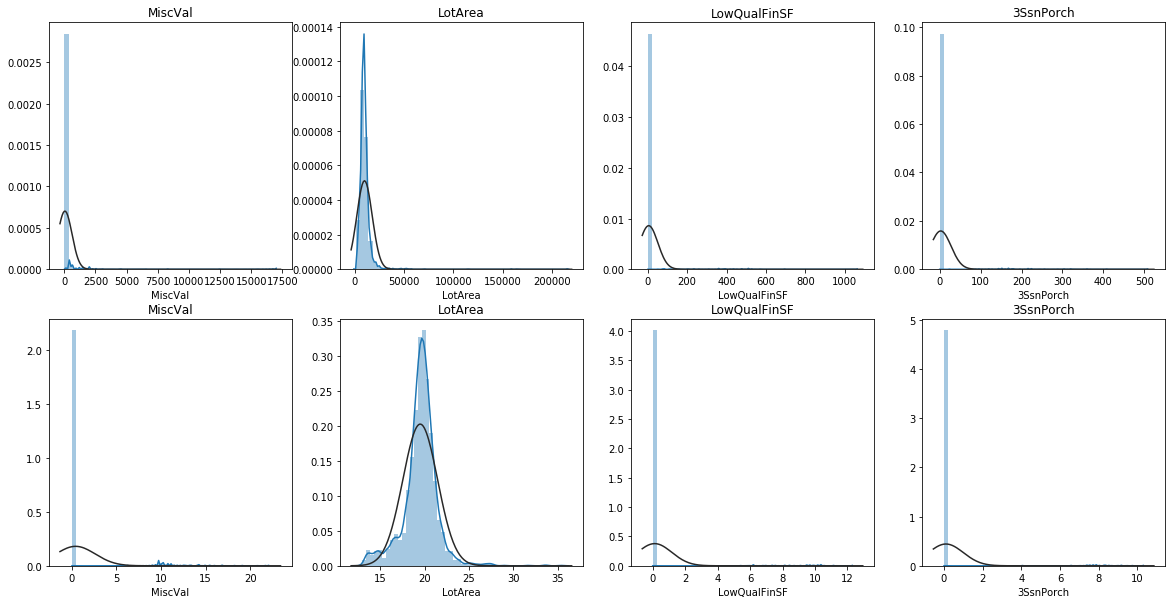

In [136]:
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
for i in range(0,4):
    sns.distplot(no_miss_data[sk_cols[i]],fit=norm,ax=axes[0,i]); axes[0,i].set_title(sk_cols[i]);
for i in range(0,4):
    sns.distplot(unskewed_data[sk_cols[i]],fit=norm,ax=axes[1,i]); axes[1,i].set_title(sk_cols[i]);

### Catagorical data encoding experiments

1. Many of the features are ordinal here i.e poor,fair,good,excelent this kind of ranked. So they were labeled by order of the mean value of sale price. But replacing with equally spaced integers i.e poor-0,good-1 made the intervel of poor and good forcely imposed to 1. So I considered to 

    {'Po': 0.0, 'Fa': 1.51, 'TA': 2.48, 'Gd': 2.9, 'Ex': 5.0}

    --replace the labels with their mean sale price 
    --MinMax Scalered the labels from 0-1
    --Multiplied them by number of ranks i.e (poor,good,fair,excellent total 4)
    Here interval between Poor and Fair is 1.51 instead of 1 and 1.51 is proportional to difference of saleprice mean which is more resonable.

    {'Po': 0.0, 'Fa': 1.51, 'TA': 2.48, 'Gd': 2.9, 'Ex': 5.0}

    ordinal encoding showed high correlation which will be shown in some plots bellow. It showed good result for cross validation error based on splits of train data but resulted poor for test data submited in kaggle.

2. Random number label encoding was also not that good, Random number encoding was done using scikit learns label encoder
3. Finally One-Hot encoding was done which performd best as many of the features are nominal also.
4. Some of the plots of ordinal encoding are still presented here for showing the correlations.

In [137]:
def ordinal_encode(_data,cols):
    data=_data.copy()
    for feat in cols: 
        dt_grp=train.groupby(feat)['SalePrice'].mean()
        dt_srt=(dt_grp.sort_values())
        dt_rsp=(np.array(dt_srt).reshape(len(dt_grp),1))
        rb=MinMaxScaler()
        dt_scl=rb.fit(dt_rsp).transform(dt_rsp)*len(dt_rsp)
        dt_scl=np.round(dt_scl,2)
        map_dict={}
        i=0
        indx=dt_srt.index
        for lb in indx:
            map_dict[lb]=dt_scl[i,0]   
            i+=1
        _data[feat]=_data[feat].map(map_dict)
        print(feat,':',map_dict)
    return _data

GarageFinish : {'Unf': 0.0, 'RFn': 2.14, 'Fin': 3.0}
GarageType : {'CarPort': 0.0, 'Detchd': 1.35, '2Types': 2.36, 'Basment': 2.5, 'Attchd': 4.33, 'BuiltIn': 6.0}
Foundation : {'Slab': 0.0, 'BrkTil': 1.57, 'CBlock': 2.79, 'Stone': 3.31, 'Wood': 4.71, 'PConc': 6.0}
FireplaceQu : {'Po': 0.0, 'Fa': 1.51, 'TA': 2.48, 'Gd': 2.9, 'Ex': 5.0}
HeatingQC : {'Po': 0.0, 'Fa': 1.59, 'TA': 2.66, 'Gd': 3.23, 'Ex': 5.0}
MasVnrType : {'BrkCmn': 0.0, 'None': 0.26, 'BrkFace': 2.13, 'Stone': 4.0}


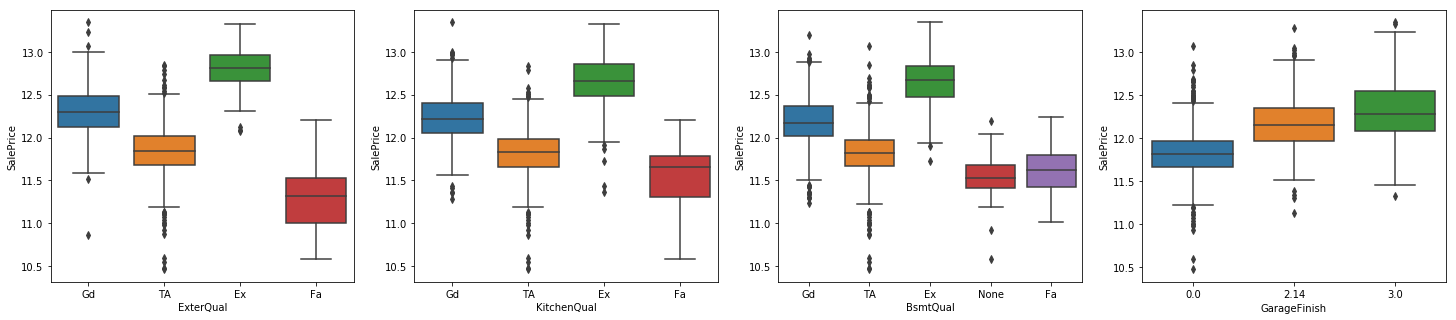

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(25,5))
enc_data=unskewed_data.copy()

num_feat,cat_feat,con_feat,dis_feat=get_feat_count(enc_data)
cm,corr_feat=get_corr_list(enc_data,cat_feat,thr=.3,enc='ord_enc')
ord_feat=['ExterQual','KitchenQual','BsmtQual','GarageFinish','FireplaceQu',
        'HeatingQC','GarageCond','BsmtFinType1','BsmtExposure','CentralAir']
enc_data=ordinal_encode(enc_data,corr_feat[4:10])
plt_enc_data=enc_data.copy()
plt_enc_data['SalePrice']=train.SalePrice
n=0
for j in range(4):
        n+=1
        sns.boxplot(x=corr_feat[n], y='SalePrice', data=plt_enc_data,ax=axes[j])
#sns.boxplot(x=corr_feat[2], y='SalePrice', data=enc_data,ax=axes[1])
#sns.boxplot(x=corr_feat[3], y='SalePrice', data=enc_data,ax=axes[2])
#sns.boxplot(x=corr_feat[4], y='SalePrice', data=enc_data,ax=axes[3])

plt.show()
#plot_box(data,corr_feat[:2]


### Scaling and One-Hot Encoding
1. One Hot Encoding is done here
2. Robust scalar performed best among (RobustScalar,MInMax Scalar,Standard Scalar)

In [139]:
scl_data=unskewed_data.copy()
print(scl_data.shape)
scl_data.replace(np.nan,0,inplace=True)
scl_data.replace(np.inf,0,inplace=True)
scl_data=scl_data.fillna(0)
scl_data = pd.get_dummies(scl_data)
print(scl_data.shape)
#print(sc_data[cc].head(3))
robust_scaler = RobustScaler()
scl_data = robust_scaler.fit(scl_data).transform(scl_data)

(2915, 81)
(2915, 305)


In [140]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train= train.SalePrice.values
_train = pd.DataFrame(scl_data[:ntrain])
_test = pd.DataFrame(scl_data[ntrain:])

In [141]:
n=int(len(train)*1.0)
_train_x=np.array(_train.loc[:n,:])
_test_x=np.array(_train.loc[:n,:])
_train_y=np.array(y_train[:n+1].reshape(-1,1))
_test_y=np.array(y_train[:n+1].reshape(-1,1))
_train_x.shape

(1456, 305)

### Preprocessing steps Vs Error   
<img style="float: left;" src="img/p_2.png">
<img style="float: left" src="img/p_4.png">
<img style="float: left" src="img/p_1.png">
<img style="float: left" src="img/summ.png">

### Linear Regression block used for checking error for each additional steps of data processing 

In [147]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

regr=linear_model.Ridge(alpha=8)
regr.fit(_train.values,y_train)
#res=regr.predict(np.array(_test.values))

score1=cross_val_score(regr, _train.values, (y_train), scoring="neg_mean_squared_error",cv = 10)
score2=cross_val_score(regr, _train.values, y_train, scoring="r2",cv = 10)
msle=np.abs(score1.mean())
print('Mean MSLE',msle)
print('Mean RMSLE',np.sqrt(msle))
print('Mean R2 Correlation',score2.mean())

Mean MSLE 0.012313903066315813
Mean RMSLE 0.11096802722548425
Mean R2 Correlation 0.9216997086256249


In [144]:
rres_exp=np.exp(res)
print(len(rres_exp))
data='Id,SalePrice\n'
Id=1461
for row in rres_exp:
    data+=str(Id)+','+str(row)+'\n'
    Id+=1
file=open('sub24_LR_One-Hot_enc.csv','w')
file.write(data)
file.close()

1459


In [145]:
#rres_exp=rres_exp.reshape(-1)
#rres_exp[1089]=70000
np.argmax(rres_exp)
#rres_exp[1089]=700000

1089

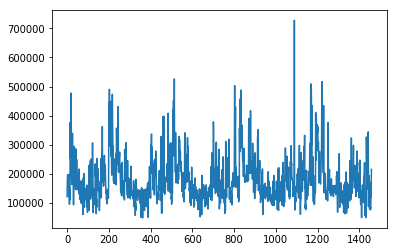

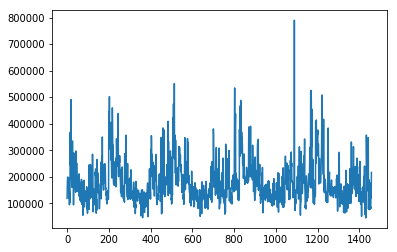

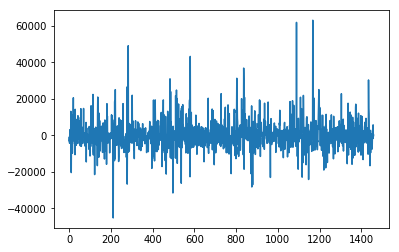

0.0015237401456063592


In [146]:
from sklearn.metrics import mean_squared_error
test_check=pd.read_csv('submission.csv')
c_res=test_check['SalePrice']
plt.plot(c_res)
plt.show()
plt.plot(rres_exp)
plt.show()
plt.plot(rres_exp-c_res)
plt.show()
er=mean_squared_error(np.log(rres_exp),np.log(c_res))
print(er)